<a href="https://colab.research.google.com/github/shinchan75034/TFE_TFRecord/blob/master/From_Single_Observation_to_TFRecord.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## From an observation's raw data to `TFRecord`
Handling raw data as input to Tensorflow's workflow is actually quite complicated. This notebook takes a minimalist approach to converting raw data into `TFRecord`, which is a recommended and fundamental format for storing raw data as a binary string. This example demonstrates: \

1. convert a raw `jpg` image to `TFRecord` \
    raw data -> `tf.train.Feature` -> `tf.train.Features` -> `tf.train.Example` -> `TFRecord`
2. store `TFRecord` \
3. load `TFRecord` back \
4. display `TFRecord` as image \

Tensorflow 2.1.0 is the core of Tensorflow Enterprise 2.1 LTS distribution. GPU is used as a hardware accelerator in this example.

In [0]:
!pip install tensorflow-gpu==2.1.0

In [0]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(tf.__version__)
print(device_lib.list_local_devices())

### Providing a raw image

Upload a jpg image from local machine. The uploaded file is stored at current working directory.

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Kistefos-Museum_BIG_dezeen_936_5.jpg to Kistefos-Museum_BIG_dezeen_936_5.jpg


In [3]:
!ls -lrt *.jpg*

-rw-r--r-- 1 root root 106209 Apr 13 18:39 Kistefos-Museum_BIG_dezeen_936_5.jpg


Lets encode the filename as a variable for convenience, then display the image:

In [0]:
building = 'Kistefos-Museum_BIG_dezeen_936_5.jpg'

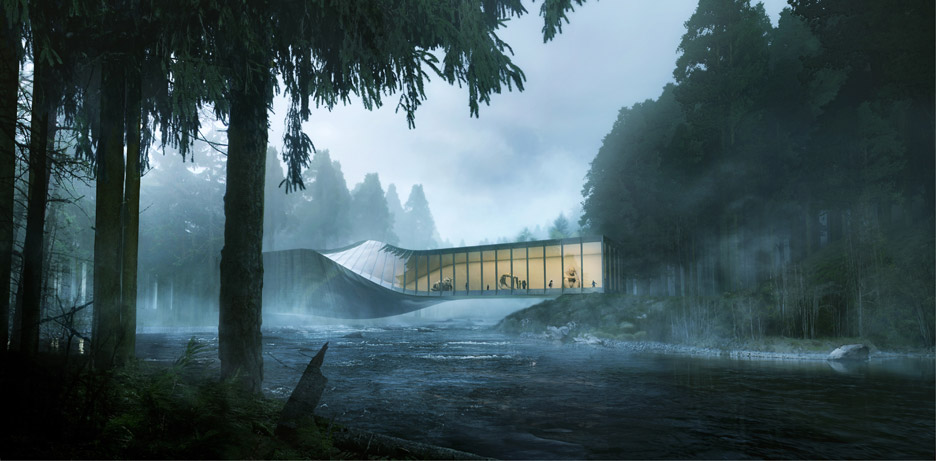

In [5]:
import numpy as np
import IPython.display as display
display.display(display.Image(filename=building))
display.display(display.HTML('Image cc-by: <a "href=https://www.kistefosmuseum.com/">Kistefos Museum</a>'))

### Creating a label dictionary

Lets provide a label for this image. The label is provided as a key-value pair in the format of Python dictionary. Since we are only working with one image in this example, there is only one KV pair. And since we encoded the file name as a variable, the key is likewise represented as a variable in the dictionary declaration.

In [0]:
image_labels = {
    building : 0,
    
}

Ensure key and value in `image_labels` are correct.

In [7]:
image_labels.items()

dict_items([('Kistefos-Museum_BIG_dezeen_936_5.jpg', 0)])

This dictionary is a key-value pair. The key is path to file, the value is label. The key is passed as a variable, therefore no double quote is used in defining dictionary key. This image can be read as a byte string, and we may verify its shape.

In [0]:
image_string = open(building, 'rb').read()

In [9]:
type(image_string)

bytes

In [0]:
label = image_labels[building]

In [11]:
label

0

In [0]:
image_shape = tf.image.decode_jpeg(image_string).shape

In [13]:
image_shape

TensorShape([461, 936, 3])

### Creating a dictionary to hold an observation's metadata and content as a byte string

An observation in this case is an image. It can be described by properties such as height, width, depth, and actual content as in byte string. Eventually we want to encapsulate all these properties in a data structure known as `tf.train.Example`. But first, we need to encapsulate the metadata of this image (height, width, depth) and the data as byte string. So we need to create a feature dictionary as a collection of key-value pair. \

We need to use some [helper functions](https://www.tensorflow.org/tutorials/load_data/tfrecord#tfexample "helper functions provided by Tensorflow team") for this process. 

In [0]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [0]:
feature_dictionary = {
      'height': _int64_feature(image_shape[0]),
      'width': _int64_feature(image_shape[1]),
      'depth': _int64_feature(image_shape[2]),
      'label': _int64_feature(label),
      'image_raw': _bytes_feature(image_string),
  }

Lets convert it to `Features` type, then `Example` type.

In [0]:
features_msg = tf.train.Features(feature=feature_dictionary) # output type tensorflow.core.example.feature_pb2.Features

In [0]:
example_msg = tf.train.Example(features=features_msg) # output type tensorflow.core.example.example_pb2.Example

In [0]:
for line in str(example_msg).split('\n'):
  print(line)

`Example` has a nested key-value pair structure, it has the look and feel of JSON message. In Tensorflow, `Example` type is known as a protocol buffer. 

### Writing a TFRecord

In [0]:
# Write the raw image files to `images.tfrecords`.
# Now the image is processed into `tf.Example` message,
# lets write it to a `.tfrecords` file.
record_file = 'images.tfrecords'
with tf.io.TFRecordWriter(record_file) as writer:
  for filename, label in image_labels.items():
    image_string = open(filename, 'rb').read()
    tf_example = example_msg
    writer.write(tf_example.SerializeToString())

In [24]:
!du -sh {record_file}

104K	images.tfrecords


Now the image is successfully written as a `TFRecord` file.

In [0]:
raw_image_dataset = tf.data.TFRecordDataset('images.tfrecords')

In [26]:
!ls -lrt

total 316
drwxr-xr-x 1 root root   4096 Apr  3 16:24 sample_data
-rw-r--r-- 1 root root 106209 Apr 13 18:39 Kistefos-Museum_BIG_dezeen_936_5.jpg
-rw-r--r-- 1 root root 106323 Apr 13 18:40 image.tfrecords
-rw-r--r-- 1 root root 106323 Apr 13 18:40 images.tfrecords


In [27]:
type(raw_image_dataset)

tensorflow.python.data.ops.readers.TFRecordDatasetV2

In [0]:
for line in raw_image_dataset:
  print(line)

### Loading a TFRecord

Lets load back what we just stored. Since we stored it in the current working directory, we only need to specify the file name. Use `tf.data.TFRecordDataset` to read the `tfrecords` file.

In [0]:
my_dataset = tf.data.TFRecordDataset('images.tfrecords')

In [30]:
my_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [0]:
for my_raw_record in my_dataset.take(10):
  print(repr(my_raw_record))
  print(str(my_raw_record))

In [0]:
my_raw_record

In [33]:
type(my_raw_record)

tensorflow.python.framework.ops.EagerTensor

### Providing a Feature Description Dictionary

We may parse the TFRecord with a dictionary that correctly anticipates metadata and the raw data's byte string.

In [0]:
# Create a dictionary describing the features.
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}


In [0]:
returned_holder = tf.io.parse_single_example(my_raw_record, image_feature_description )

Lets take a look at what is returned. It should be a dictionary as a collection of key-value pairs, which encapsulates all metadata and raw data as a byte string.

In [0]:
returned_holder

In [0]:
returned_holder['image_raw']

Convert image byte string to `numpy`, then display it.

In [0]:
returned_holder['image_raw'].numpy()

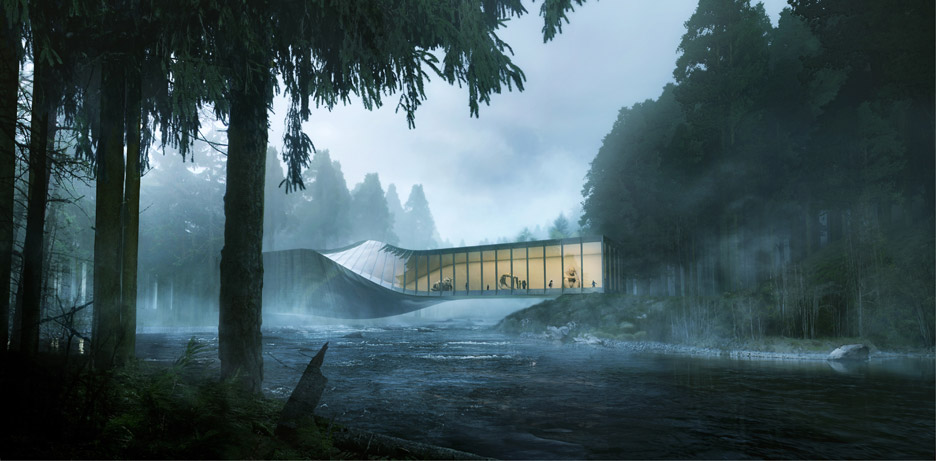

In [40]:
display.display(display.Image(data=returned_holder['image_raw'].numpy()))

### Reference
[TFRecord and tf.Example](https://www.tensorflow.org/tutorials/load_data/tfrecord "Tensorflow documentation")